In [ ]:
import pandas as pd
from tdmsdata import TdmsData
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import curve_fit   
from scipy.signal import fftconvolve
from scipy.stats import exponnorm
import statsmodels.api as sm
import os
import importlib
import doppler_shift_2024
import satlas2 as st

In [2]:
def read_tdms(folder_path, file, channel):
    TDMS = TdmsData(''.join([folder_path, file]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array, channel 1 = RAES, channel 3 = ID gated signal, channel 4 = ID gated bkg, channel 5 = nongated
    return raw_data

In [3]:
def create_df(raw_data):
    return pd.DataFrame({'Cycle No.': raw_data[:, 0], 'Time (sec)': raw_data[:, 1], 
                         'Laser Frequency (THz)': raw_data[:, 2], 'Approx Time': raw_data[:, 3], # Approx time is a timestamp for calib and interferometer 
                         'SDUMP': raw_data[:, 4], 'LE Probe': raw_data[:, 5]}) # SDUMP is dump current of PREVIOUS cycle (nA) and LE probe is beam energy (V) 

In [4]:
def doppler_shift_calc(dataset, isotope):
    importlib.reload(doppler_shift_2024)
    doppler_df = dataset.copy()
    freq = doppler_df['Laser Frequency (THz)']
    measured_voltage = doppler_df['LE Probe']
    shifted_freq = doppler_shift_2024.getshift(freq, isotope, measured_voltage)
    doppler_df['Laser Frequency (THz)'] = shifted_freq

    return doppler_df

In [31]:
def process_data(df):
    freq = 'Laser Frequency (THz)'
    bin_width = 50
    freq_range = (df[freq].max() - df[freq].min()) * 1e6 # MHz
    bins = int(np.ceil(freq_range / bin_width)) # number of bins will change to ensure bin worth is consistent 

    binned_df = (
            df
            .assign(Freq_bin=lambda df: pd.cut(df[freq], bins))
            .groupby('Freq_bin', observed=True) # separate counts for each bin and cycle
            .size()
            .reset_index(name='Count raw')
            .assign(Bin_center=lambda df: df['Freq_bin'].apply(lambda x: x.mid))
        )
    
    binned_df.columns = ['Freq bin', 'Count raw', 'Bin center']

    binned_df['Freq bin'] = binned_df['Freq bin'].astype('category')  # Match global dtype
    binned_df['Bin center'] = binned_df['Bin center'].astype(float)

    return binned_df

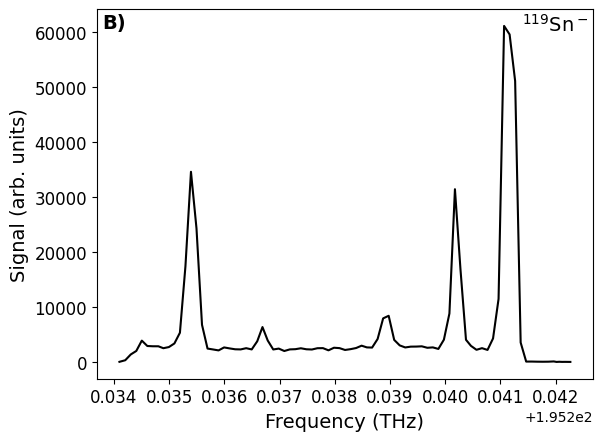

                  Freq bin  Count raw  Bin center
0   (195.23407, 195.23413]         19  195.234100
1   (195.23418, 195.23423]        308  195.234205
2   (195.23428, 195.23433]       1359  195.234305
3   (195.23438, 195.23443]       1996  195.234405
4   (195.23448, 195.23453]       3877  195.234505
..                     ...        ...         ...
80  (195.24199, 195.24204]          1  195.242015
81  (195.24204, 195.24209]         29  195.242065
82  (195.24209, 195.24214]          7  195.242115
83  (195.24214, 195.24219]         14  195.242165
84  (195.24224, 195.24229]          3  195.242265

[85 rows x 3 columns]


In [ ]:
folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/odds/'
file = '20241022_2251_Sn_119_.48to.535_0.0003nms.tdms'
channel = 1

raw_data = read_tdms(folder_path, file, channel)
data_df = create_df(raw_data)
doppler_df = doppler_shift_calc(data_df, 119)
binned_df = process_data(doppler_df)

plt.xlabel('Frequency (THz)', fontsize=14)
plt.ylabel('Signal (arb. units)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.plot(binned_df['Bin center'], binned_df['Count raw'], color='black')
plt.text(0.01, 0.99, 'B)', transform=plt.gca().transAxes,
         fontsize=14, fontweight='bold', va='top', ha='left')
plt.text(0.99, 0.99, '$^{119}$Sn$^-$', transform=plt.gca().transAxes,
         fontsize=14, va='top', ha='right')
# plt.savefig(f"{file}.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()
print(binned_df)